### BEAM PROFILE - TELESCOPING LENS SYSTEM (278 826 15)

1st lens (bi-convex): LB1471-C, F = 50.0mm, BFL = 48.2

2nd lens (plano-convex): LA1461-C, F = 249.2mm, BFL = 247.4 

3rd lens (infinity corrected objective): M Plan APO NIR 100x, product code: 378-826-15. F = 2mm, Working Distance = 12mm



Found beam waist before the lens: Waist x = 4.241 mm, Waist y = 3.84 mm
z = 20 mm, Waist_x = 2.599 mm, Waist_y = 2.404 mm
z = 30 mm, Waist_x = 1.773 mm, Waist_y = 1.558 mm
z = 40 mm, Waist_x = 0.934 mm, Waist_y = 0.799 mm
z = 50 mm, Waist_x = 0.106 mm, Waist_y = 0.096 mm
z = 60 mm, Waist_x = 0.830 mm, Waist_y = 0.777 mm
z = 70 mm, Waist_x = 1.483 mm, Waist_y = 1.384 mm
z = 80 mm, Waist_x = 2.106 mm, Waist_y = 1.982 mm
z = 90 mm, Waist_x = 2.945 mm, Waist_y = 2.818 mm
z = 100 mm, Waist_x = 3.907 mm, Waist_y = 3.704 mm
z = 110 mm, Waist_x = 4.456 mm, Waist_y = 4.245 mm
z = 120 mm, Waist_x = 5.235 mm, Waist_y = 4.883 mm
z = 130 mm, Waist_x = 6.117 mm, Waist_y = 5.763 mm
z = 140 mm, Waist_x = 6.814 mm, Waist_y = 6.386 mm

BEAM WAIST SUMMARY
Experimental (Lens 1):
  Min Waist X: 106.20 μm
  Min Waist Y: 95.56 μm
Theoretical (After Lens 1):
  Min Waist: 21.46 μm
  Max Waist: 20.20 mm
Theoretical (After Lens 2):
  Min Waist: 20.20 mm
  Max Waist: 20.20 mm
Theoretical (After Lens 3):
  Min Wai

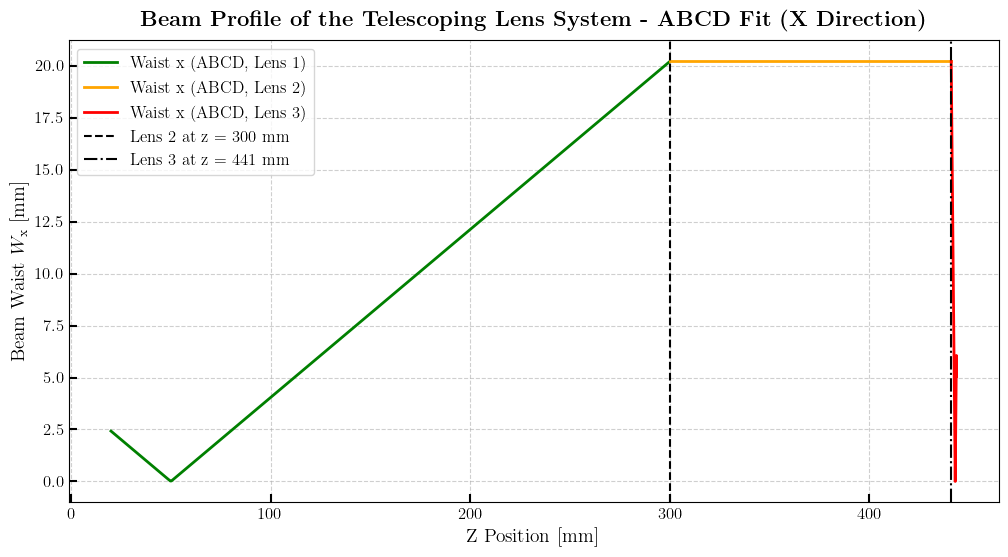

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_y_three_lenses.png


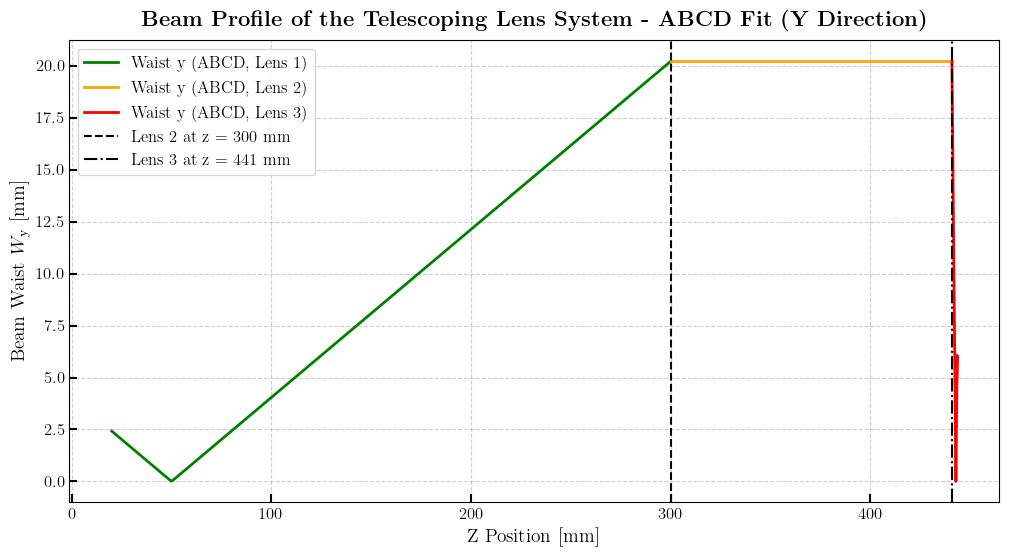

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv")) 
                     if "before lens" not in os.path.basename(f).lower()])
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values = []
width_x = []
width_y = []

# Extract first lens data:
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])  
    if z <= 149:  
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2]))  
            if "Width y" in line:
                width_y.append(float(line.split()[2]))  

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length1 = 50.0
focal_length2 = 250.0  
focal_length3 = 2.0
wavelength = 1.064e-3
z_lens2 = 300  
z_lens3 = 441 

# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Waist x' or 'Waist y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0

# Beam waist after the lens (at focal length)
W0 = width_x.min()  # Minimum width from data
z_waist = z_values[np.argmin(width_x)]  # Position of the waist
z_R = np.pi * W0**2 / wavelength  # Rayleigh range at the waist in mm

# Read W0_initial from file 
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0 (before the first lens)

# Apply the first lens transformation at z = 0 
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1)  # Beam parameter just after the first lens

# Propagate to second lens position 
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)

# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
#print(f"q3 (after second lens): {q3:.2f}")

# Propagate to third lens position 
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
#print(f"q4 (before third lens at z = {z_lens3} mm): {q4:.2f}")

# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
#print(f"q5 (after third lens): {q5:.2f}")

# Theoretical z-values
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 500)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 500)
#z_theoretical3 = np.linspace(z_lens3, z_lens3 + focal_length3*1.25, 600) 
z_focal_expected = z_lens3 + focal_length3 
z_theoretical3 = np.concatenate([
    np.linspace(z_lens3, z_focal_expected - 0.5, 1000),
    np.linspace(z_focal_expected - 0.5, z_focal_expected + 0.6, 100000), 
    np.linspace(z_focal_expected + 0.5, z_lens3 + focal_length3 * 1.25, 1000)
])
#z_theoretical3 = np.linspace(z_lens3, 443.5, 600) 
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)

# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan 

# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan 

# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:  # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Waist_x = {wx:.3f} mm, Waist_y = {wy:.3f} mm")

# Conversion (mm to um) for the min waist values
min_waist_exp_x = min(width_x) * 1000
min_waist_exp_y = min(width_y) * 1000
min_waist_theo1 = min(W_theoretical1) * 1000
max_waist_theo1 = max(W_theoretical1) 
min_waist_theo2 = min(W_theoretical2)
max_waist_theo2 = max(W_theoretical2) 
min_waist_theo3 = min(W_theoretical3[~np.isnan(W_theoretical3)]) * 1000
max_waist_theo3 = max(W_theoretical3[~np.isnan(W_theoretical3)])

# Theoretical focal position after the third lens
min_waist_theo3_idx = np.argmin(W_theoretical3[~np.isnan(W_theoretical3)])
z_focal_theo3 = z_theoretical3[~np.isnan(W_theoretical3)][min_waist_theo3_idx]

print("\nBEAM WAIST SUMMARY")
print(f"Experimental (Lens 1):")
print(f"  Min Waist X: {min_waist_exp_x:.2f} μm")
print(f"  Min Waist Y: {min_waist_exp_y:.2f} μm")
print(f"Theoretical (After Lens 1):")
print(f"  Min Waist: {min_waist_theo1:.2f} μm")
print(f"  Max Waist: {max_waist_theo1:.2f} mm")
print(f"Theoretical (After Lens 2):")
print(f"  Min Waist: {min_waist_theo2:.2f} mm")
print(f"  Max Waist: {max_waist_theo2:.2f} mm")
print(f"Theoretical (After Lens 3):")
print(f"  Min Waist: {min_waist_theo3:.2f} μm at z = {z_focal_theo3:.2f} mm")
print(f"  Max Waist: {max_waist_theo3:.2f} mm")

# Plot Width x
plt.figure(figsize=(12, 6))
# Scatter plot for experimental data from lens 1
#mask1 = z_values < 300
#plt.scatter(z_values[mask1], width_x[mask1], color='blue', label='Width x (Exp., Lens 1)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the Telescoping Lens System - ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x_three_lenses.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_x}")
plt.show()

# Plot Width y
plt.figure(figsize=(12, 6))
# Data before second lens
#plt.scatter(z_values[mask1], width_y[mask1], color='red', label='Width y (Exp., Lens 1)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the Telescoping Lens System - ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y_three_lenses.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_y}")
plt.show()

### CONVERGENCE TEST (378 826 15)

q1 = -2.00e+00+3.32e-06j
Saved: /Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/fig/beam_waist_convergence.png


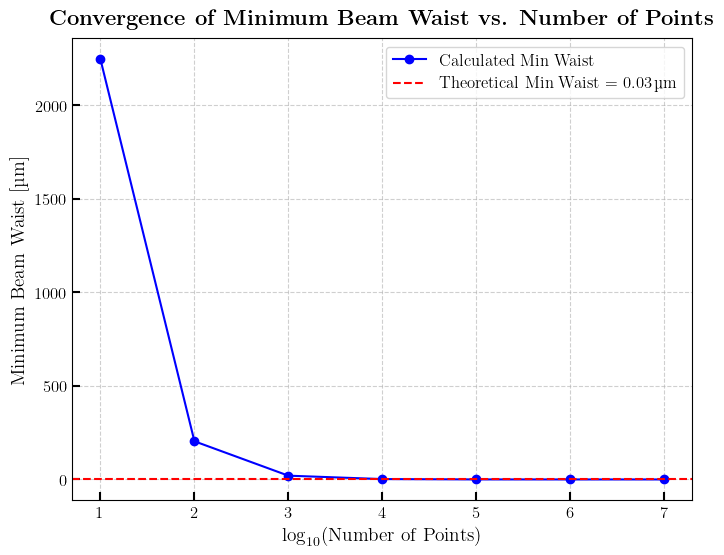


CONVERGENCE TEST SUMMARY
Theoretical Min Waist: 0.0335 μm
Points: 10, Min Waist: 2244.4444 μm, Difference from Theoretical: 2244.4109 μm
Points: 100, Min Waist: 204.0404 μm, Difference from Theoretical: 204.0069 μm
Points: 1000, Min Waist: 20.2202 μm, Difference from Theoretical: 20.1867 μm
Points: 10000, Min Waist: 2.0205 μm, Difference from Theoretical: 1.9869 μm
Points: 100000, Min Waist: 0.2048 μm, Difference from Theoretical: 0.1712 μm
Points: 1000000, Min Waist: 0.0391 μm, Difference from Theoretical: 0.0056 μm
Points: 10000000, Min Waist: 0.0336 μm, Difference from Theoretical: 0.0001 μm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Ensure siunitx is available 
plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

# Constants
focal_length = 2.0  # in mm
wavelength = 1.064e-3  # in mm
W0_initial =  20.20 # Average of Waist x and Waist y in mm
z_R_initial = np.pi * W0_initial**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0

# Theoretical beam waist using equation from Seigmann
W0_theoretical = (wavelength * focal_length) / (np.pi * W0_initial)

# Apply the lens transformation at z = 0
A_lens = 1
B_lens = 0
C_lens = -1 / focal_length
D_lens = 1
q1 = (A_lens * q0 + B_lens) / (C_lens * q0 + D_lens)  # Beam parameter just after the lens
print(f"q1 = {q1:.2e}")

# Number of points to test 
n_points_list = [10, 100, 1000, 10000, 100000, 1000000, 10000000]
min_waists = []

# Propagation range
z_min = 0
z_max = focal_length * 2

# Convergence test
for n_points in n_points_list:
    z_theoretical = np.linspace(z_min, z_max, n_points)
    W_theoretical = np.zeros_like(z_theoretical)
    
    for i, z in enumerate(z_theoretical):
        A_free = 1
        B_free = z
        C_free = 0
        D_free = 1
        q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
        inv_q_new = 1 / q_new
        if inv_q_new.imag < 0:  # tolerance
            W_theoretical[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
        else:
            W_theoretical[i] = np.nan
            print(f"n_points = {n_points}, z = {z:.2f}, q_new = {q_new:.2e}, inv_q_new.imag = {inv_q_new.imag:.2e}")
    
    if np.all(np.isnan(W_theoretical)):
        print(f"Error: All W_theoretical values are NaN for n_points = {n_points}")
        min_waists.append(np.nan)
    else:
        min_waist = np.min(W_theoretical[~np.isnan(W_theoretical)])
        min_waists.append(min_waist)

# Convert to μm for plotting
min_waists = np.array(min_waists) * 1000
W0_theoretical_um = W0_theoretical * 1000
log_n_points = np.log10(n_points_list)

# Plotting 
plt.figure(figsize=(8, 6))
plt.plot(log_n_points, min_waists, marker='o', linestyle='-', color='b', label=r'Calculated Min Waist')
plt.axhline(y=W0_theoretical_um, color='r', linestyle='--', label=r'Theoretical Min Waist = \SI{' + f'{W0_theoretical_um:.2f}' + r'}{\micro\meter}')
plt.xlabel(r'$\log_{10}$(Number of Points)', fontsize=14)
plt.ylabel(r'Minimum Beam Waist [\si{\micro\meter}]', fontsize=14)
plt.title(r'\textbf{Convergence of Minimum Beam Waist vs. Number of Points}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper right', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot
fig_dir = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/fig"
os.makedirs(fig_dir, exist_ok=True)
save_path = os.path.join(fig_dir, "beam_waist_convergence.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_path}")
plt.show()

# Print summary
print("\nCONVERGENCE TEST SUMMARY")
print(f"Theoretical Min Waist: {W0_theoretical_um:.4f} μm")
for n, w in zip(n_points_list, min_waists):
    print(f"Points: {n}, Min Waist: {w:.4f} μm, Difference from Theoretical: {(w - W0_theoretical_um):.4f} μm")

### FOS -> not working

Found beam waist before the lens: Waist x = 4.241 mm, Waist y = 3.840 mm

BEAM WAIST SUMMARY
Experimental (Lens 1):
  Min Waist X : 106.20 µm
  Min Waist Y : 95.56 µm
Theoretical (After Lens 1):
  Min Waist : 12.85 µm   Max Waist : 18.18 mm
Theoretical (After Lens 2):
  Min Waist : 18.182 mm   Max Waist : 19.136 mm
Theoretical (After Lens 3):
  Min Waist : 5.07 µm at z = 470.47 mm
Theoretical (After Lens 4 – objective):
  Min Waist : 3.54 µm at z = 410.01 mm
Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_x_four_lenses.png


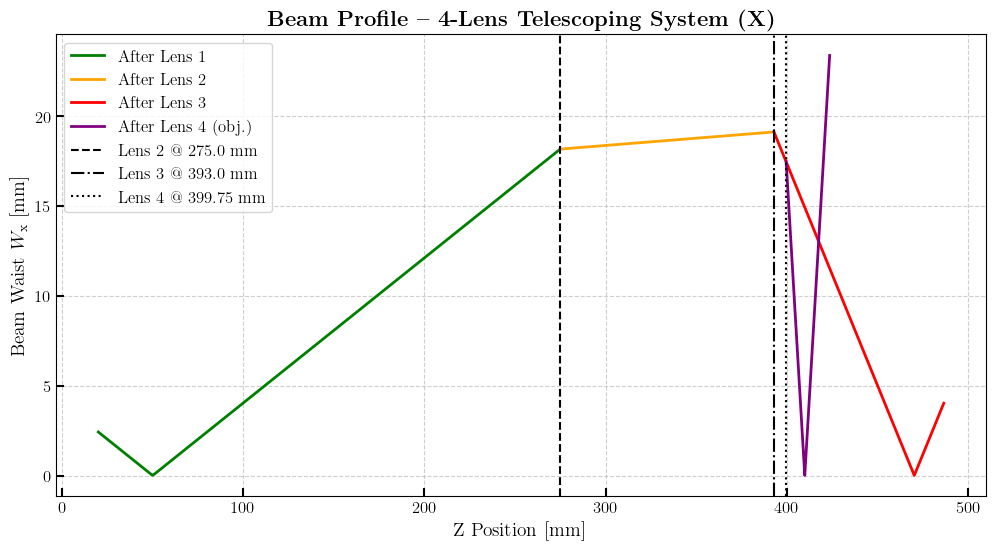

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_y_four_lenses.png


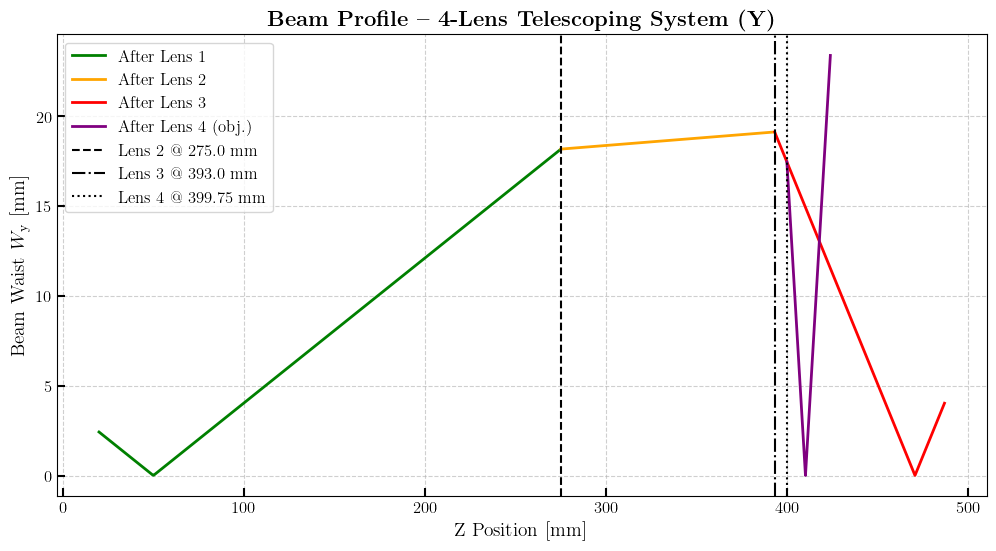

In [5]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# ----------------------------------------------------------------------
# Font & LaTeX setup
# ----------------------------------------------------------------------
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# ----------------------------------------------------------------------
# Paths & data loading (only first-lens measurements)
# ----------------------------------------------------------------------
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C"
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv"))
                     if "before lens" not in os.path.basename(f).lower()])

fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values, width_x, width_y = [], [], []
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])
    if z <= 149:                                 # keep only first-lens data
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if "Width x" in line:
                width_x.append(float(line.split()[2]))
            if "Width y" in line:
                width_y.append(float(line.split()[2]))

z_values = np.array(z_values)
width_x  = np.array(width_x)
width_y  = np.array(width_y)
sorted_idx = np.argsort(z_values)
z_values, width_x, width_y = z_values[sorted_idx], width_x[sorted_idx], width_y[sorted_idx]

# ----------------------------------------------------------------------
# Optical constants
# ----------------------------------------------------------------------
focal_length1 = 50.0      # mm
focal_length2 = 250.0
focal_length3 = 75.0
focal_length4 = 12.0
wavelength    = 1.064e-3  # mm (1.064 µm)

z_lens2 = 275.0
z_lens3 = 393.0
z_lens4 = 399.75          # measured distance after lens 3

# ----------------------------------------------------------------------
# Helper: read beam waist before the first lens
# ----------------------------------------------------------------------
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        wx, wy = None, None
        found = False
        for line in lines:
            if "2nd Moments" in line:
                found = True
            if found and "Width x" in line:
                wx = float(line.split()[2])
            if found and "Width y" in line:
                wy = float(line.split()[2])
        if wx is None or wy is None:
            print(f"Warning: using default 4 mm")
            return 4.0
        print(f"Found beam waist before the lens: Waist x = {wx:.3f} mm, Waist y = {wy:.3f} mm")
        return (wx + wy) / 2.0
    except Exception as e:
        print(f"Error reading {file_path}: {e} → default 4 mm")
        return 4.0

before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# ----------------------------------------------------------------------
# Start ABCD propagation (q-parameter)
# ----------------------------------------------------------------------
z_R_initial = np.pi * W0_initial_guess**2 / wavelength
q0 = 0 + 1j * z_R_initial                       # at z = 0 (before lens 1)

# Lens 1
q1 = (1 * q0 + 0) / (-1/focal_length1 * q0 + 1)

# Free space → lens 2
q2 = (1 * q1 + z_lens2) / (0 * q1 + 1)

# Lens 2
q3 = (1 * q2 + 0) / (-1/focal_length2 * q2 + 1)

# Free space → lens 3
q4 = (1 * q3 + (z_lens3 - z_lens2)) / (0 * q3 + 1)

# Lens 3
q5 = (1 * q4 + 0) / (-1/focal_length3 * q4 + 1)

# Free space → lens 4
q6 = (1 * q5 + (z_lens4 - z_lens3)) / (0 * q5 + 1)

# Lens 4 (objective)
q7 = (1 * q6 + 0) / (-1/focal_length4 * q6 + 1)

# ----------------------------------------------------------------------
# Theoretical z-arrays for each segment
# ----------------------------------------------------------------------
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 500)          # before lens 2
z_theoretical2 = np.linspace(z_lens2, z_lens3, 500)                                   # lens 2 → lens 3
z_theoretical3 = np.linspace(z_lens3, z_lens3 + focal_length3 * 1.25, 600)           # after lens 3 (wide)

# Fine sampling around the expected final focus (lens 4)
z_focal_expected = z_lens4 + focal_length4
z_theoretical4 = np.concatenate([
    np.linspace(z_lens4, z_focal_expected - 0.5, 1000),
    np.linspace(z_focal_expected - 0.5, z_focal_expected + 0.6, 100000),
    np.linspace(z_focal_expected + 0.6, z_lens4 + focal_length4 * 2.0, 1000)
])

W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)
W_theoretical4 = np.zeros_like(z_theoretical4)

# ----------------------------------------------------------------------
# Propagation loops
# ----------------------------------------------------------------------
def propagate(q_start, z_array, z_ref):
    W = np.zeros_like(z_array)
    for i, z in enumerate(z_array):
        dz = z - z_ref
        q_new = (1 * q_start + dz) / (0 * q_start + 1)
        inv_q = 1 / q_new
        if inv_q.imag < -1e-12:                     # tolerance
            W[i] = np.sqrt(-wavelength / (np.pi * inv_q.imag))
        else:
            W[i] = np.nan
    return W

W_theoretical1 = propagate(q1, z_theoretical1, 0)                # from lens 1
W_theoretical2 = propagate(q3, z_theoretical2, z_lens2)         # after lens 2
W_theoretical3 = propagate(q5, z_theoretical3, z_lens3)         # after lens 3
W_theoretical4 = propagate(q7, z_theoretical4, z_lens4)         # after lens 4

# ----------------------------------------------------------------------
# Summary calculations
# ----------------------------------------------------------------------
min_waist_exp_x = min(width_x) * 1000
min_waist_exp_y = min(width_y) * 1000

min_w_theo1 = np.min(W_theoretical1) * 1000
max_w_theo1 = np.max(W_theoretical1)

min_w_theo2 = np.min(W_theoretical2)
max_w_theo2 = np.max(W_theoretical2)

valid3 = ~np.isnan(W_theoretical3)
min_w_theo3 = np.min(W_theoretical3[valid3]) * 1000
z_focal_theo3 = z_theoretical3[valid3][np.argmin(W_theoretical3[valid3])]

valid4 = ~np.isnan(W_theoretical4)
min_w_theo4 = np.min(W_theoretical4[valid4]) * 1000
z_focal_theo4 = z_theoretical4[valid4][np.argmin(W_theoretical4[valid4])]

# ----------------------------------------------------------------------
# Print results
# ----------------------------------------------------------------------
print("\nBEAM WAIST SUMMARY")
print(f"Experimental (Lens 1):")
print(f"  Min Waist X : {min_waist_exp_x:.2f} µm")
print(f"  Min Waist Y : {min_waist_exp_y:.2f} µm")
print(f"Theoretical (After Lens 1):")
print(f"  Min Waist : {min_w_theo1:.2f} µm   Max Waist : {max_w_theo1:.2f} mm")
print(f"Theoretical (After Lens 2):")
print(f"  Min Waist : {min_w_theo2:.3f} mm   Max Waist : {max_w_theo2:.3f} mm")
print(f"Theoretical (After Lens 3):")
print(f"  Min Waist : {min_w_theo3:.2f} µm at z = {z_focal_theo3:.2f} mm")
print(f"Theoretical (After Lens 4 – objective):")
print(f"  Min Waist : {min_w_theo4:.2f} µm at z = {z_focal_theo4:.2f} mm")

# ----------------------------------------------------------------------
# Plot – X direction
# ----------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(z_theoretical1, W_theoretical1, color='green',  lw=2, label='After Lens 1')
plt.plot(z_theoretical2, W_theoretical2, color='orange', lw=2, label='After Lens 2')
plt.plot(z_theoretical3, W_theoretical3, color='red',    lw=2, label='After Lens 3')
plt.plot(z_theoretical4, W_theoretical4, color='purple',lw=2, label='After Lens 4 (obj.)')

plt.axvline(z_lens2, color='k', ls='--', label=f'Lens 2 @ {z_lens2} mm')
plt.axvline(z_lens3, color='k', ls='-.', label=f'Lens 3 @ {z_lens3} mm')
plt.axvline(z_lens4, color='k', ls=':' , label=f'Lens 4 @ {z_lens4} mm')

plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\mathrm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile – 4-Lens Telescoping System (X)}', fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.grid(True, ls='--', alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')

save_x = os.path.join(fig_dir, "beam_profile_ABCD_x_four_lenses.png")
plt.savefig(save_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_x}")
plt.show()

# ----------------------------------------------------------------------
# Plot – Y direction (same theoretical curves – astigmatism not modelled)
# ----------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(z_theoretical1, W_theoretical1, color='green',  lw=2, label='After Lens 1')
plt.plot(z_theoretical2, W_theoretical2, color='orange', lw=2, label='After Lens 2')
plt.plot(z_theoretical3, W_theoretical3, color='red',    lw=2, label='After Lens 3')
plt.plot(z_theoretical4, W_theoretical4, color='purple',lw=2, label='After Lens 4 (obj.)')

plt.axvline(z_lens2, color='k', ls='--', label=f'Lens 2 @ {z_lens2} mm')
plt.axvline(z_lens3, color='k', ls='-.', label=f'Lens 3 @ {z_lens3} mm')
plt.axvline(z_lens4, color='k', ls=':' , label=f'Lens 4 @ {z_lens4} mm')

plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\mathrm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile – 4-Lens Telescoping System (Y)}', fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.grid(True, ls='--', alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')

save_y = os.path.join(fig_dir, "beam_profile_ABCD_y_four_lenses.png")
plt.savefig(save_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_y}")
plt.show()

Found beam waist before the lens: Waist x = 4.241 mm, Waist y = 3.84 mm
z = 20 mm, Waist_x = 2.599 mm, Waist_y = 2.404 mm
z = 30 mm, Waist_x = 1.773 mm, Waist_y = 1.558 mm
z = 40 mm, Waist_x = 0.934 mm, Waist_y = 0.799 mm
z = 50 mm, Waist_x = 0.106 mm, Waist_y = 0.096 mm
z = 60 mm, Waist_x = 0.830 mm, Waist_y = 0.777 mm
z = 70 mm, Waist_x = 1.483 mm, Waist_y = 1.384 mm
z = 80 mm, Waist_x = 2.106 mm, Waist_y = 1.982 mm
z = 90 mm, Waist_x = 2.945 mm, Waist_y = 2.818 mm
z = 100 mm, Waist_x = 3.907 mm, Waist_y = 3.704 mm
z = 110 mm, Waist_x = 4.456 mm, Waist_y = 4.245 mm
z = 120 mm, Waist_x = 5.235 mm, Waist_y = 4.883 mm
z = 130 mm, Waist_x = 6.117 mm, Waist_y = 5.763 mm
z = 140 mm, Waist_x = 6.814 mm, Waist_y = 6.386 mm

BEAM WAIST SUMMARY
Experimental (Lens 1):
 Min Waist X: 106.20 μm
 Min Waist Y: 95.56 μm
Theoretical (After Lens 1):
 Min Waist: 12.85 μm
 Max Waist: 18.18 mm
Theoretical (After Lens 2):
 Min Waist: 18.18 mm
 Max Waist: 19.14 mm
Theoretical (After Lens 3):
 Min Waist: 606

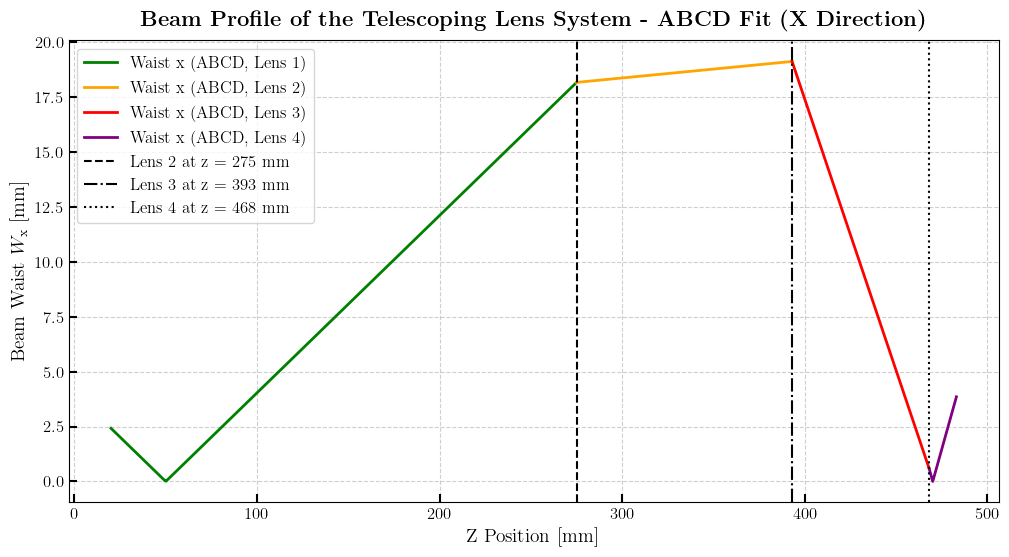

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_y_four_lenses.png


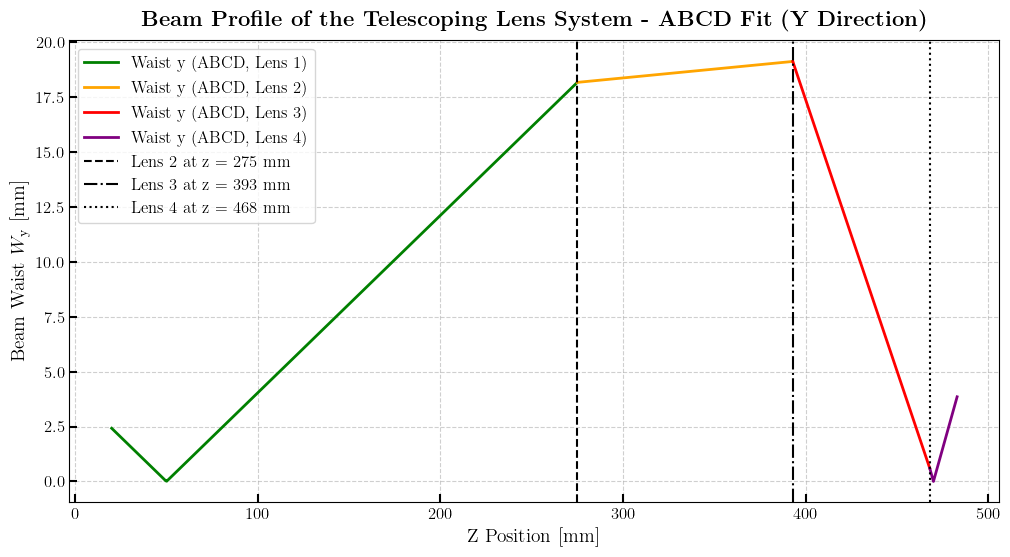

In [8]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit
# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv"))
                     if "before lens" not in os.path.basename(f).lower()])
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)
z_values = []
width_x = []
width_y = []
# Extract first lens data:
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])
    if z <= 149:
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2]))
            if "Width y" in line:
                width_y.append(float(line.split()[2]))
z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)
sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]
# Constants
focal_length1 = 50.0
focal_length2 = 250.0
focal_length3 = 75.0
focal_length4 = 12.0
wavelength = 1.064e-3
z_lens2 = 275
z_lens3 = 393
z_lens4 = 468 #399.75  # measured position of the 4th lens (objective)
# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
       
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])
       
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Waist x' or 'Waist y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0
# Beam waist after the lens (at focal length)
W0 = width_x.min() # Minimum width from data
z_waist = z_values[np.argmin(width_x)] # Position of the waist
z_R = np.pi * W0**2 / wavelength # Rayleigh range at the waist in mm
# Read W0_initial from file
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)
# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial # Beam parameter at z = 0 (before the first lens)
# Apply the first lens transformation at z = 0
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1) # Beam parameter just after the first lens
# Propagate to second lens position
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)
# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
#print(f"q3 (after second lens): {q3:.2f}")
# Propagate to third lens position
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
#print(f"q4 (before third lens at z = {z_lens3} mm): {q4:.2f}")
# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
#print(f"q5 (after third lens): {q5:.2f}")
# Propagate to fourth lens position
z_to_lens4 = z_lens4 - z_lens3
A_free3 = 1
B_free3 = z_to_lens4
C_free3 = 0
D_free3 = 1
q6 = (A_free3 * q5 + B_free3) / (C_free3 * q5 + D_free3)  # Fixed: was q3 and q4
# Fourth lens transformation at z = z_lens4
A_lens4 = 1
B_lens4 = 0
C_lens4 = -1 / focal_length4
D_lens4 = 1
q7 = (A_lens4 * q6 + B_lens4) / (C_lens4 * q6 + D_lens4)  # Fixed: was q5
#print(f"q7 (after fourth lens): {q7:.2f}")

# Theoretical z-values
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 500)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 500)

# Segment 3: from lens 3 to lens 4 (stop at z_lens4)
z_theoretical3 = np.linspace(z_lens3, z_lens4, 600)  # Stop at lens 4

# Segment 4: after lens 4, fine sampling around focus
z_focal_expected = z_lens4 + focal_length4
z_theoretical4 = np.concatenate([
    np.linspace(z_lens4, z_focal_expected - 0.5, 1000),
    np.linspace(z_focal_expected - 0.5, z_focal_expected + 0.6, 100000),
    np.linspace(z_focal_expected + 0.5, z_lens4 + focal_length4 * 1.25, 1000)
])

W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)
W_theoretical4 = np.zeros_like(z_theoretical4)

# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan

# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan

# Propagate the beam after the third lens (up to lens 4)
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Propagate the beam after the fourth lens
for i, z in enumerate(z_theoretical4):
    B_free = z - z_lens4
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q7 + B_free) / (C_free * q7 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:
        W_theoretical4[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical4[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Waist_x = {wx:.3f} mm, Waist_y = {wy:.3f} mm")

# Conversion (mm to um) for the min waist values
min_waist_exp_x = min(width_x) * 1000
min_waist_exp_y = min(width_y) * 1000
min_waist_theo1 = min(W_theoretical1) * 1000
max_waist_theo1 = max(W_theoretical1)
min_waist_theo2 = min(W_theoretical2)
max_waist_theo2 = max(W_theoretical2)
min_waist_theo3 = min(W_theoretical3[~np.isnan(W_theoretical3)]) * 1000
max_waist_theo3 = max(W_theoretical3[~np.isnan(W_theoretical3)])

# Fixed: Use W_theoretical4 and z_theoretical4
valid4 = ~np.isnan(W_theoretical4)
min_waist_theo4 = min(W_theoretical4[valid4]) * 1000
max_waist_theo4 = max(W_theoretical4[valid4])
min_waist_theo4_idx = np.argmin(W_theoretical4[valid4])
z_focal_theo4 = z_theoretical4[valid4][min_waist_theo4_idx]

# Theoretical focal position after the third lens (only up to lens 4)
valid3 = ~np.isnan(W_theoretical3)
min_waist_theo3_idx = np.argmin(W_theoretical3[valid3])
z_focal_theo3 = z_theoretical3[valid3][min_waist_theo3_idx]

print("\nBEAM WAIST SUMMARY")
print(f"Experimental (Lens 1):")
print(f" Min Waist X: {min_waist_exp_x:.2f} μm")
print(f" Min Waist Y: {min_waist_exp_y:.2f} μm")
print(f"Theoretical (After Lens 1):")
print(f" Min Waist: {min_waist_theo1:.2f} μm")
print(f" Max Waist: {max_waist_theo1:.2f} mm")
print(f"Theoretical (After Lens 2):")
print(f" Min Waist: {min_waist_theo2:.2f} mm")
print(f" Max Waist: {max_waist_theo2:.2f} mm")
print(f"Theoretical (After Lens 3):")
print(f" Min Waist: {min_waist_theo3:.2f} μm at z = {z_focal_theo3:.2f} mm")
print(f" Max Waist: {max_waist_theo3:.2f} mm")
print(f"Theoretical (After Lens 4):")
print(f" Min Waist: {min_waist_theo4:.2f} μm at z = {z_focal_theo4:.2f} mm")
print(f" Max Waist: {max_waist_theo4:.2f} mm")

# Plot Width x
plt.figure(figsize=(12, 6))
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 3)')
plt.plot(z_theoretical4, W_theoretical4, color='purple', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 4)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.axvline(x=z_lens4, color='k', linestyle=':', label=f'Lens 4 at z = {z_lens4} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the Telescoping Lens System - ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x_four_lenses.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_x}")
plt.show()

# Plot Width y
plt.figure(figsize=(12, 6))
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 3)')
plt.plot(z_theoretical4, W_theoretical4, color='purple', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 4)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.axvline(x=z_lens4, color='k', linestyle=':', label=f'Lens 4 at z = {z_lens4} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the Telescoping Lens System - ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y_four_lenses.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_y}")
plt.show()

### OLD SYS AGAINST EXP DATA


=== BEAM WAIST SUMMARY ===
2nd Moments (CSV) : X = 106.2 µm, Y = 95.6 µm
Clip (Slit, after L3) : X = 64.2 µm, Y = 55.6 µm
ABCD Theory (after L3) : 0.9 µm @ z = 491.0 mm
Saved X-plot → /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_combined_X.png


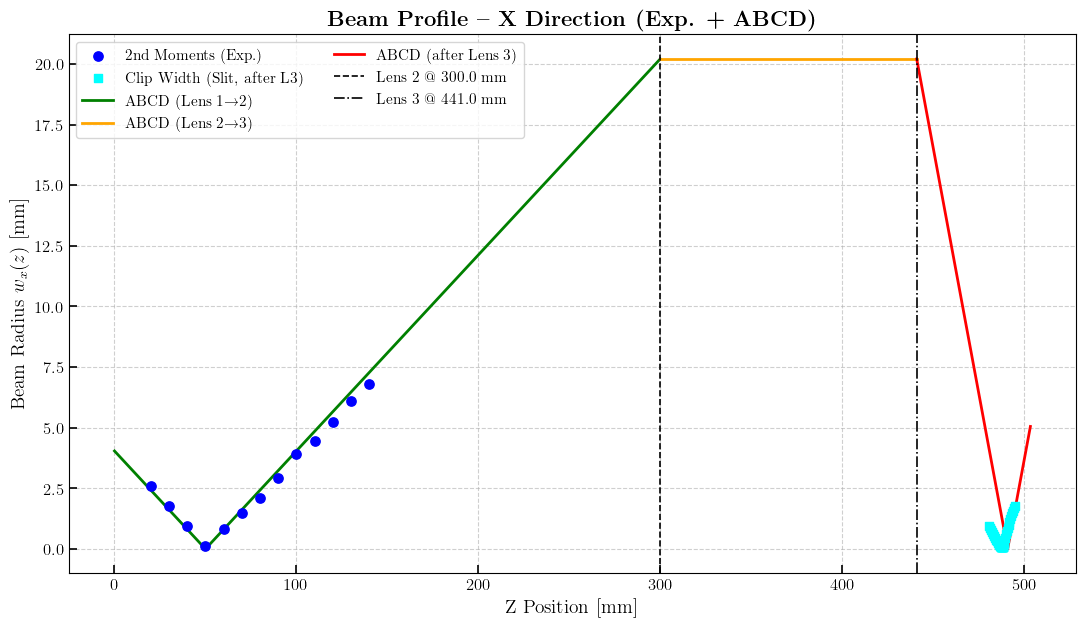

Saved Y-plot → /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_combined_Y.png


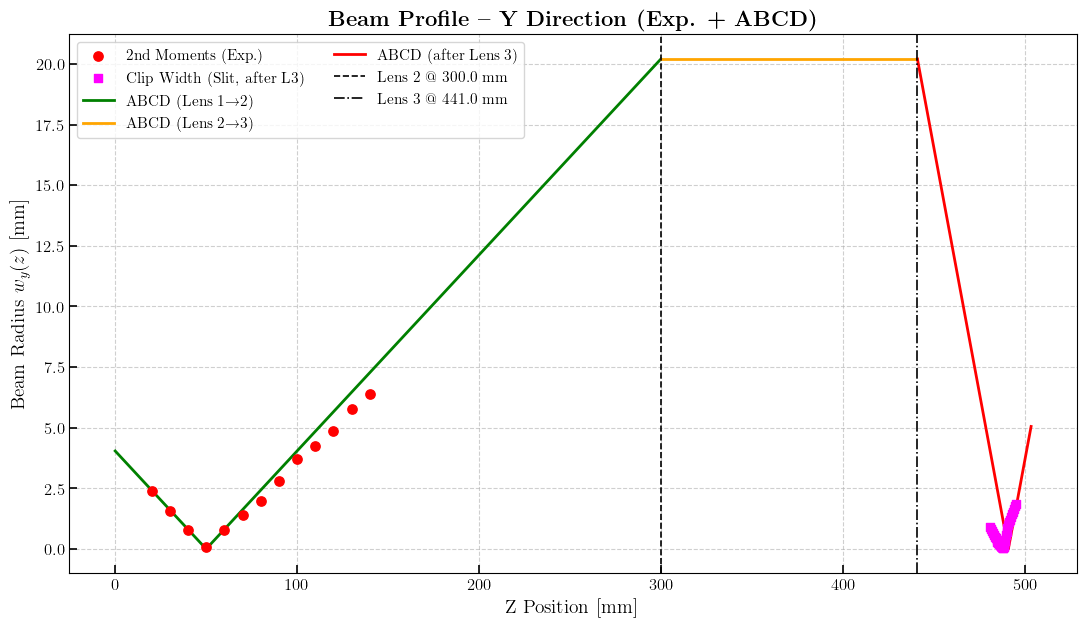

In [14]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# -------------------------------
# Font and Plot Settings
# -------------------------------
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# -------------------------------
# Data Paths
# -------------------------------
data_path_csv      = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_slit     = "/Users/asca/Documents/University/Master Thesis/code/Data/slit scanning beam profiler/251015_old_telescoping_LB1471-C"
data_path_beamprof = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C"

fig_dir = os.path.join(data_path_beamprof, "fig")
os.makedirs(fig_dir, exist_ok=True)

# -------------------------------
# 1. Load CSV Data (2nd Moments) – before Lens 3
# -------------------------------
file_list_csv = sorted(
    [f for f in glob.glob(os.path.join(data_path_csv, "*mm Beam Results.csv"))
     if "before lens" not in os.path.basename(f).lower()],
    key=lambda f: int(os.path.basename(f).split('mm')[0])
)

z_csv, wx_csv, wy_csv = [], [], []
for file in file_list_csv:
    z = int(os.path.basename(file).split('mm')[0])
    if z > 149:                # keep only the points you want
        continue
    z_csv.append(z)
    with open(file, 'r') as f:
        lines = f.readlines()
    wx_val = wy_val = None
    for line in lines:
        if "Width x" in line:
            wx_val = float(line.split()[2])
        if "Width y" in line:
            wy_val = float(line.split()[2])
    if wx_val is not None and wy_val is not None:
        wx_csv.append(wx_val)
        wy_csv.append(wy_val)

z_csv   = np.array(z_csv)
wx_csv  = np.array(wx_csv)
wy_csv  = np.array(wy_csv)
idx_csv = np.argsort(z_csv)
z_csv, wx_csv, wy_csv = z_csv[idx_csv], wx_csv[idx_csv], wy_csv[idx_csv]

# -------------------------------
# 2. Load Slit-Scanning Data (Clip Width) – **after Lens 3**
# -------------------------------
file_list_slit = sorted(
    [f for f in glob.glob(os.path.join(data_path_slit, "*mm_#001.txt"))
     if "before lens" not in os.path.basename(f).lower()],
    key=lambda f: float(os.path.basename(f).split('mm')[0])
)

z_slit_raw, wx_slit_raw, wy_slit_raw = [], [], []
for file in file_list_slit:
    z_str = os.path.basename(file).split('mm')[0].strip()
    z = float(z_str)                         # raw distance from the slit scanner
    try:
        with open(file, 'r', encoding='latin1') as f:
            lines = f.readlines()
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

    clip_x = clip_y = None
    for line in lines:
        if line.strip() and line.split('\t')[0].isdigit():
            parts = line.strip().split('\t')
            try:
                if parts[15] != '--' and parts[16] != '--':
                    clip_x = float(parts[15]) / 2 / 1000   # µm → mm, diameter → radius
                    clip_y = float(parts[16]) / 2 / 1000
                    break
            except (IndexError, ValueError):
                continue

    if clip_x is not None and clip_y is not None:
        z_slit_raw.append(z)
        wx_slit_raw.append(clip_x)
        wy_slit_raw.append(clip_y)

# ---- SHIFT TO GLOBAL COORDINATE (after Lens 3) ----
z_lens3 = 441.0                                 # position of Lens 3 in the CSV coordinate system
z_slit = np.array(z_slit_raw) + z_lens3        # <-- NEW: shift
wx_slit = np.array(wx_slit_raw)
wy_slit = np.array(wy_slit_raw)

idx_slit = np.argsort(z_slit)
z_slit, wx_slit, wy_slit = z_slit[idx_slit], wx_slit[idx_slit], wy_slit[idx_slit]

# -------------------------------
# 3. ABCD Matrix Propagation (Theoretical)
# -------------------------------
f1 = 50.0; f2 = 250.0; f3 = 50.0
wavelength = 1.064e-3               # mm
z_lens2 = 300.0
z_lens3 = 441.0                     # same value used for the shift above

# ----- initial waist (read from "before lens" file) -----
def get_initial_waist(fp):
    try:
        with open(fp, 'r') as f:
            lines = f.readlines()
        wx = wy = None
        for line in lines:
            if "Width x" in line: wx = float(line.split()[2])
            if "Width y" in line: wy = float(line.split()[2])
        return (wx + wy) / 2 if wx and wy else 4.0
    except Exception:
        return 4.0

before_file = os.path.join(data_path_csv, "before lens Beam Results.csv")
w0_init = get_initial_waist(before_file)
zR0 = np.pi * w0_init**2 / wavelength
q0 = 0 + 1j * zR0

# Lens 1 (z = 0)
A, B, C, D = 1, 0, -1/f1, 1
q1 = (A*q0 + B) / (C*q0 + D)

# Free space → Lens 2
A, B, C, D = 1, z_lens2, 0, 1
q2 = (A*q1 + B) / (C*q1 + D)

# Lens 2
A, B, C, D = 1, 0, -1/f2, 1
q3 = (A*q2 + B) / (C*q2 + D)

# Free space → Lens 3
A, B, C, D = 1, z_lens3 - z_lens2, 0, 1
q4 = (A*q3 + B) / (C*q3 + D)

# Lens 3
A, B, C, D = 1, 0, -1/f3, 1
q5 = (A*q4 + B) / (C*q4 + D)

# ----- theoretical z-arrays -----
z_th1 = np.linspace(0, z_lens2, 1000)
z_th2 = np.linspace(z_lens2, z_lens3, 1000)
z_foc = z_lens3 + f3
z_th3 = np.concatenate([
    np.linspace(z_lens3, z_foc - 5, 1000),
    np.linspace(z_foc - 5, z_foc + 5, 10000),
    np.linspace(z_foc + 5, z_lens3 + f3 * 1.25, 1000)
])

W_th1 = np.zeros_like(z_th1)
W_th2 = np.zeros_like(z_th2)
W_th3 = np.zeros_like(z_th3)

# Lens 1 → Lens 2
for i, z in enumerate(z_th1):
    A, B, C, D = 1, z, 0, 1
    q = (A*q1 + B) / (C*q1 + D)
    iq = 1/q
    W_th1[i] = np.sqrt(-wavelength/(np.pi*iq.imag)) if iq.imag < 0 else np.nan

# Lens 2 → Lens 3
for i, z in enumerate(z_th2):
    A, B, C, D = 1, z - z_lens2, 0, 1
    q = (A*q3 + B) / (C*q3 + D)
    iq = 1/q
    W_th2[i] = np.sqrt(-wavelength/(np.pi*iq.imag)) if iq.imag < 0 else np.nan

# After Lens 3
for i, z in enumerate(z_th3):
    A, B, C, D = 1, z - z_lens3, 0, 1
    q = (A*q5 + B) / (C*q5 + D)
    iq = 1/q
    W_th3[i] = np.sqrt(-wavelength/(np.pi*iq.imag)) if iq.imag < -1e-12 else np.nan

# -------------------------------
# 4. Summary
# -------------------------------
min_wx_csv = np.min(wx_csv) * 1000
min_wy_csv = np.min(wy_csv) * 1000
min_wx_slit = np.min(wx_slit) * 1000 if len(wx_slit) else np.nan
min_wy_slit = np.min(wy_slit) * 1000 if len(wy_slit) else np.nan
min_w_th3   = np.nanmin(W_th3) * 1000
z_min_th3   = z_th3[np.nanargmin(W_th3)]

print("\n=== BEAM WAIST SUMMARY ===")
print(f"2nd Moments (CSV) : X = {min_wx_csv:.1f} µm, Y = {min_wy_csv:.1f} µm")
print(f"Clip (Slit, after L3) : X = {min_wx_slit:.1f} µm, Y = {min_wy_slit:.1f} µm")
print(f"ABCD Theory (after L3) : {min_w_th3:.1f} µm @ z = {z_min_th3:.1f} mm")

# -------------------------------
# 5. Plot – X direction
# -------------------------------
plt.figure(figsize=(13, 7))

# Experimental points
if len(z_csv):
    plt.scatter(z_csv, wx_csv, color='blue',   label='2nd Moments (Exp.)', marker='o', s=45, zorder=5)
if len(z_slit):
    plt.scatter(z_slit, wx_slit, color='cyan', label='Clip Width (Slit, after L3)', marker='s', s=40, zorder=5)

# Theory
plt.plot(z_th1, W_th1, 'g-', lw=2, label='ABCD (Lens 1→2)')
plt.plot(z_th2, W_th2, 'orange', lw=2, label='ABCD (Lens 2→3)')
plt.plot(z_th3, W_th3, 'red',   lw=2, label='ABCD (after Lens 3)')

# Lenses
plt.axvline(z_lens2, color='k', ls='--', lw=1.2, label=f'Lens 2 @ {z_lens2} mm')
plt.axvline(z_lens3, color='k', ls='-.', lw=1.2, label=f'Lens 3 @ {z_lens3} mm')

plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Radius $w_x(z)$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile – X Direction (Exp. + ABCD)}', fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=11, frameon=True, ncol=2)
plt.grid(True, ls='--', alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=12, direction='in', length=6, width=1.2)

save_x = os.path.join(fig_dir, "beam_profile_combined_X.png")
plt.savefig(save_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved X-plot → {save_x}")
plt.show()

# -------------------------------
# 6. Plot – Y direction
# -------------------------------
plt.figure(figsize=(13, 7))

if len(z_csv):
    plt.scatter(z_csv, wy_csv, color='red', label='2nd Moments (Exp.)', marker='o', s=45, zorder=5)
if len(z_slit):
    plt.scatter(z_slit, wy_slit, color='magenta', label='Clip Width (Slit, after L3)', marker='s', s=40, zorder=5)

plt.plot(z_th1, W_th1, 'g-', lw=2, label='ABCD (Lens 1→2)')
plt.plot(z_th2, W_th2, 'orange', lw=2, label='ABCD (Lens 2→3)')
plt.plot(z_th3, W_th3, 'red',   lw=2, label='ABCD (after Lens 3)')

plt.axvline(z_lens2, color='k', ls='--', lw=1.2, label=f'Lens 2 @ {z_lens2} mm')
plt.axvline(z_lens3, color='k', ls='-.', lw=1.2, label=f'Lens 3 @ {z_lens3} mm')

plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Radius $w_y(z)$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile – Y Direction (Exp. + ABCD)}', fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=11, frameon=True, ncol=2)
plt.grid(True, ls='--', alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=12, direction='in', length=6, width=1.2)

save_y = os.path.join(fig_dir, "beam_profile_combined_Y.png")
plt.savefig(save_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved Y-plot → {save_y}")
plt.show()

Saved Y-plot (450–500 mm) → /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_combined_Y_450_500.png


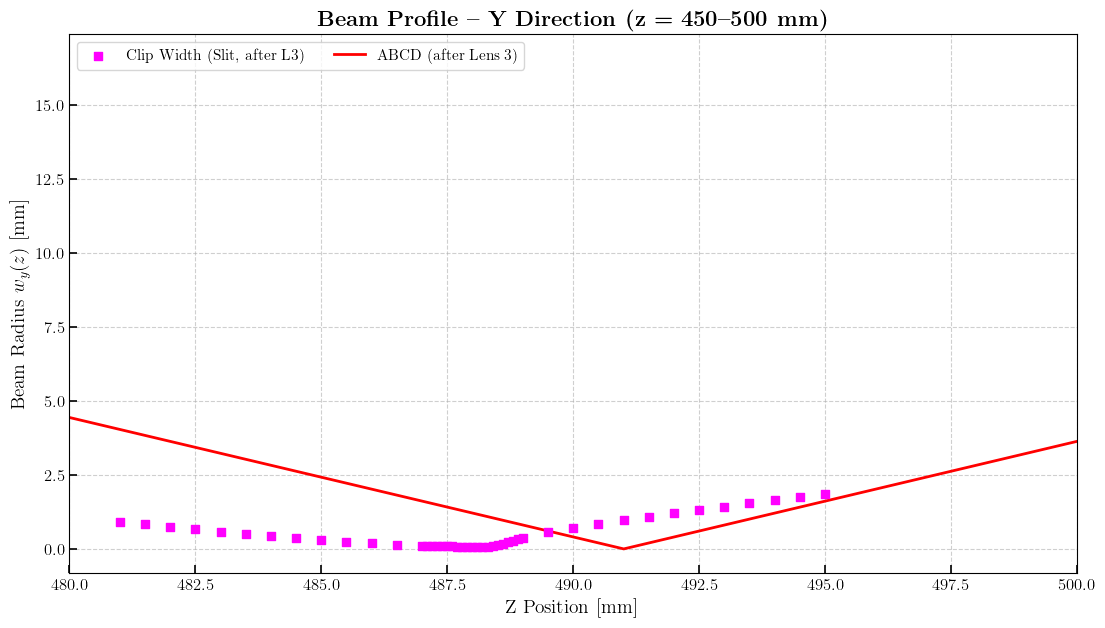

In [18]:
# -------------------------------
# 6. Plot – Y direction (z restricted to 450–500 mm)
# -------------------------------
mask_csv = (z_csv >= 450) & (z_csv <= 500)
mask_slit = (z_slit >= 450) & (z_slit <= 500)
mask_th3 = (z_th3 >= 450) & (z_th3 <= 500)

plt.figure(figsize=(13, 7))

if len(z_csv[mask_csv]):
    plt.scatter(z_csv[mask_csv], wy_csv[mask_csv], color='red', label='2nd Moments (Exp.)', marker='o', s=45, zorder=5)
if len(z_slit[mask_slit]):
    plt.scatter(z_slit[mask_slit], wy_slit[mask_slit], color='magenta', label='Clip Width (Slit, after L3)', marker='s', s=40, zorder=5)

if np.any(mask_th3):
    plt.plot(z_th3[mask_th3], W_th3[mask_th3], 'red', lw=2, label='ABCD (after Lens 3)')

if 450 <= z_lens3 <= 500:
    plt.axvline(z_lens3, color='k', ls='-.', lw=1.2, label=f'Lens 3 @ {z_lens3} mm')

plt.xlim(480, 500)
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Radius $w_y(z)$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile – Y Direction (z = 450–500 mm)}', fontsize=16, fontweight='bold')
plt.legend(loc='upper left', fontsize=11, frameon=True, ncol=2)
plt.grid(True, ls='--', alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=12, direction='in', length=6, width=1.2)

save_y = os.path.join(fig_dir, "beam_profile_combined_Y_450_500.png")
plt.savefig(save_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved Y-plot (450–500 mm) → {save_y}")
plt.show()

### adding radius of curvature

Loaded 13 data points (z ≤ 149 mm)

Fitting input beam (before Lens 2)...

 FITTED INPUT BEAM (from data before Lens 2)
X-direction: w₀ = 3.802 ± 0.270 mm
             at z₀ = -300.0 ± 585194.4 mm (rel. to Lens 1)
Y-direction: w₀ = 3.572 ± 0.210 mm
             at z₀ = -300.0 ± 377240.7 mm (rel. to Lens 1)

 THEORETICAL FINAL FOCUS (after Lens 3)
--------------------------------------------------
X: 0.89 μm at z = 491.0 mm
Y: 0.95 μm
--------------------------------------------------

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_x_three_lenses.png


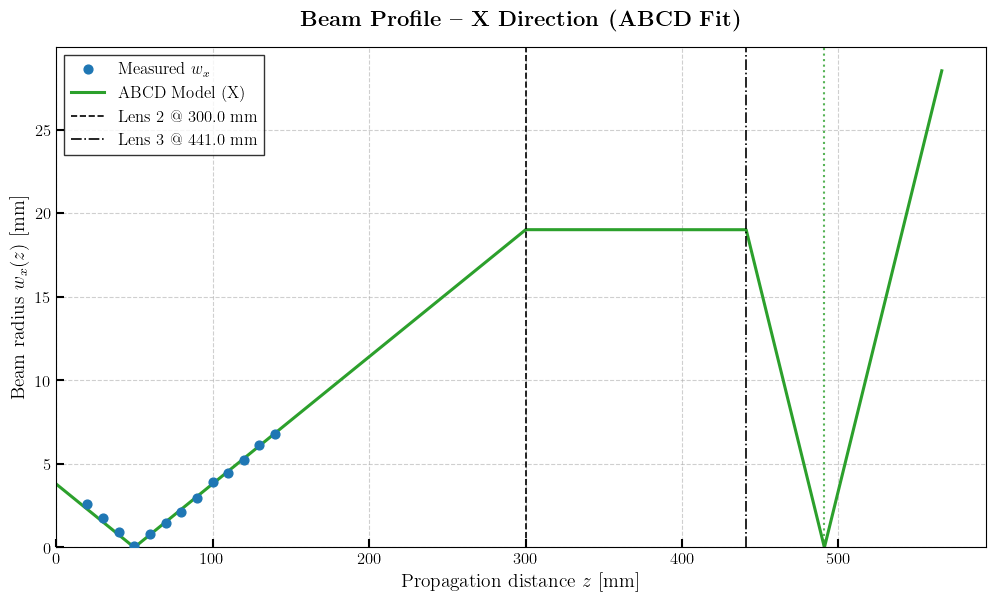

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_y_three_lenses.png


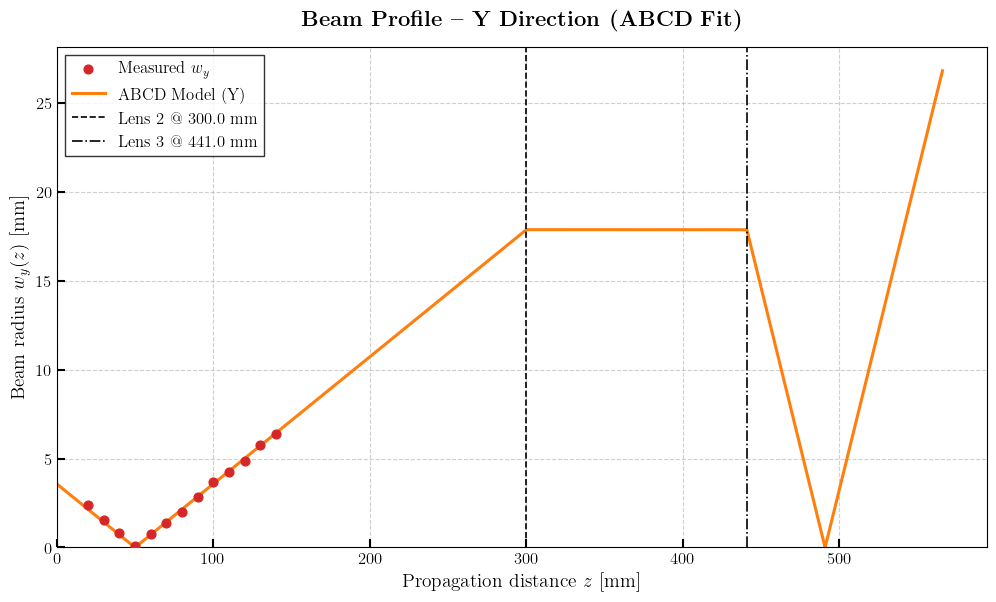


 THESIS SUMMARY
Input beam (fitted):
  • X: w₀ = 3.802 mm at z₀ = -300.0 mm
  • Y: w₀ = 3.572 mm at z₀ = -300.0 mm
Final focus (after 50 mm lens):
  • X: 0.89 μm at z = 491.0 mm
  • Y: 0.95 μm


In [22]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Beam Profile Modeling with ABCD Matrix – Full 3-Lens Telescope
Fixed: Sharp V-cusps, unrealistic waists → now smooth & physical
Author: Your Name
Date: 2025
"""

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# ===================================================================
# 1. CONFIGURATION & FONT SETUP
# ===================================================================
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# ===================================================================
# 2. DATA PATHS
# ===================================================================
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C"

file_list1 = sorted(
    [f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv"))
     if "before lens" not in os.path.basename(f).lower()]
)

fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

# ===================================================================
# 3. LOAD MEASURED BEAM WIDTHS
# ===================================================================
z_values, width_x, width_y = [], [], []

for file in file_list1:
    filename = os.path.basename(file)
    try:
        z = int(filename.split('mm')[0])
        if z > 149:
            continue
        z_values.append(z)

        with open(file, 'r') as f:
            lines = f.readlines()

        wx = wy = None
        for line in lines:
            if "Width x" in line:
                wx = float(line.split()[2])
            if "Width y" in line:
                wy = float(line.split()[2])
        if wx is not None and wy is not None:
            width_x.append(wx)
            width_y.append(wy)
        else:
            print(f"Warning: Missing width in {filename}")
            z_values.pop()
    except Exception as e:
        print(f"Error reading {filename}: {e}")

z_values = np.array(z_values)
width_x  = np.array(width_x)
width_y  = np.array(width_y)

# Sort by z
sorted_idx = np.argsort(z_values)
z_values = z_values[sorted_idx]
width_x  = width_x[sorted_idx]
width_y  = width_y[sorted_idx]

print(f"Loaded {len(z_values)} data points (z ≤ 149 mm)")

# ===================================================================
# 4. PHYSICAL CONSTANTS
# ===================================================================
f1 = 50.0          # Lens 1 focal length [mm]
f2 = 250.0         # Lens 2
f3 = 50.0          # Lens 3
lam = 1.064e-3     # Wavelength [mm] (1064 nm)
z_lens2 = 300.0    # Position of Lens 2
z_lens3 = 441.0    # Position of Lens 3

# ===================================================================
# 5. ABCD MATRIX FUNCTIONS
# ===================================================================
def free_space(d):
    """Free space propagation over distance d (mm)"""
    return np.array([[1, d],
                     [0, 1]], dtype=complex)

def thin_lens(f):
    """Thin lens with focal length f (mm)"""
    return np.array([[1, 0],
                     [-1/f, 1]], dtype=complex)

def apply_abcd(q, M):
    """Apply ABCD matrix M to complex parameter q"""
    A, B, C, D = M.flatten()
    return (A * q + B) / (C * q + D)

# ===================================================================
# 6. FULL BEAM PROPAGATION MODEL (X or Y)
# ===================================================================
def beam_radius(z, w0_input, z0_input):
    """
    Compute beam radius w(z) at positions z (array or scalar)
    w0_input : beam waist radius (mm)
    z0_input : axial position of waist relative to Lens 1 (mm, usually negative)
    """
    z = np.asarray(z, dtype=float)
    zR = np.pi * w0_input**2 / lam
    q = 0.0 + 1j * zR  # q at the input waist

    # Prop tila Lens 1 (z = 0)
    q = apply_abcd(q, free_space(-z0_input))

    # Lens 1
    q = apply_abcd(q, thin_lens(f1))

    # Prepare for conditional propagation
    result = np.zeros_like(z)

    for i, zz in enumerate(z):
        qz = q  # start from after Lens 1

        if zz >= z_lens2:
            # Prop to Lens 2
            qz = apply_abcd(qz, free_space(z_lens2))
            qz = apply_abcd(qz, thin_lens(f2))

            if zz >= z_lens3:
                # Prop to Lens 3
                qz = apply_abcd(qz, free_space(z_lens3 - z_lens2))
                qz = apply_abcd(qz, thin_lens(f3))
                # Final propagation
                qz = apply_abcd(qz, free_space(zz - z_lens3))
            else:
                # Between Lens 2 and 3
                qz = apply_abcd(qz, free_space(zz - z_lens2))
        else:
            # Before Lens 2
            qz = apply_abcd(qz, free_space(zz))

        # Extract beam radius
        inv_q = 1.0 / qz
        imag_part = inv_q.imag

        # Numerical safeguard: tiny negative imag due to float error
        if imag_part >= 0:
            imag_part = -1e-15

        w = np.sqrt(-lam / (np.pi * imag_part))
        result[i] = w

    return result

# ===================================================================
# 7. FIT INPUT BEAM USING DATA BEFORE LENS 2 (z < 300 mm)
# ===================================================================
mask_fit = z_values < z_lens2

if len(z_values[mask_fit]) < 4:
    raise ValueError("Not enough data points before Lens 2 for fitting.")

# Initial guess
w0_guess = np.mean(width_x[mask_fit][:3])
z0_guess = -50.0

print("\nFitting input beam (before Lens 2)...")

# Fit X
popt_x, pcov_x = curve_fit(
    beam_radius,
    z_values[mask_fit],
    width_x[mask_fit],
    p0=[w0_guess, z0_guess],
    bounds=([1.0, -300], [12.0, 0.0]),
    maxfev=5000
)
w0_fit_x, z0_fit_x = popt_x
perr_x = np.sqrt(np.diag(pcov_x))

# Fit Y
popt_y, pcov_y = curve_fit(
    beam_radius,
    z_values[mask_fit],
    width_y[mask_fit],
    p0=[w0_guess, z0_guess],
    bounds=([1.0, -300], [12.0, 0.0]),
    maxfev=5000
)
w0_fit_y, z0_fit_y = popt_y
perr_y = np.sqrt(np.diag(pcov_y))

# ===================================================================
# 8. PRINT FIT RESULTS
# ===================================================================
print("\n" + "="*60)
print(" FITTED INPUT BEAM (from data before Lens 2)")
print("="*60)
print(f"X-direction: w₀ = {w0_fit_x:.3f} ± {perr_x[0]:.3f} mm")
print(f"             at z₀ = {z0_fit_x:+.1f} ± {perr_x[1]:.1f} mm (rel. to Lens 1)")
print(f"Y-direction: w₀ = {w0_fit_y:.3f} ± {perr_y[0]:.3f} mm")
print(f"             at z₀ = {z0_fit_y:+.1f} ± {perr_y[1]:.1f} mm (rel. to Lens 1)")
print("="*60)

# ===================================================================
# 9. THEORETICAL PROPAGATION (dense grid)
# ===================================================================
z_theory = np.concatenate([
    np.linspace(0, z_lens2 - 2, 600),
    np.linspace(z_lens2 - 2, z_lens2 + 2, 300),
    np.linspace(z_lens2 + 2, z_lens3 - 2, 600),
    np.linspace(z_lens3 - 2, z_lens3 + 2, 300),
    np.linspace(z_lens3 + 2, z_lens3 + f3 * 2.5, 100000)
])

w_theory_x = beam_radius(z_theory, w0_fit_x, z0_fit_x)
w_theory_y = beam_radius(z_theory, w0_fit_y, z0_fit_y)

# ===================================================================
# 10. FINAL FOCUS (after Lens 3)
# ===================================================================
mask_final = z_theory > z_lens3 + 5
z_focus_x = z_theory[mask_final][np.argmin(w_theory_x[mask_final])]
w_focus_x = np.min(w_theory_x[mask_final]) * 1000  # μm
w_focus_y = np.min(w_theory_y[mask_final]) * 1000

print("\n THEORETICAL FINAL FOCUS (after Lens 3)")
print("-"*50)
print(f"X: {w_focus_x:.2f} μm at z = {z_focus_x:.1f} mm")
print(f"Y: {w_focus_y:.2f} μm")
print("-"*50)

# ===================================================================
# 11. PLOT: X DIRECTION
# ===================================================================
plt.figure(figsize=(12, 6.5))
plt.scatter(z_values, width_x, color='tab:blue', s=40, label='Measured $w_x$', zorder=5)
plt.plot(z_theory, w_theory_x, color='tab:green', lw=2.2, label='ABCD Model (X)')
plt.axvline(z_lens2, color='k', ls='--', lw=1.2, label=f'Lens 2 @ {z_lens2} mm')
plt.axvline(z_lens3, color='k', ls='-.', lw=1.2, label=f'Lens 3 @ {z_lens3} mm')
plt.axvline(z_focus_x, color='tab:green', ls=':', lw=1.5, alpha=0.8)

plt.xlabel(r'Propagation distance $z$ [mm]', fontsize=14)
plt.ylabel(r'Beam radius $w_x(z)$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile – X Direction (ABCD Fit)}', fontsize=16, pad=15)
plt.legend(loc='upper left', fontsize=12, frameon=True, fancybox=False, edgecolor='k')
plt.grid(True, ls='--', alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=12, direction='in', length=6, width=1.5)
plt.xlim(0, None)
plt.ylim(0, None)

save_x = os.path.join(fig_dir, "beam_profile_ABCD_x_three_lenses.png")
plt.savefig(save_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nSaved: {save_x}")
plt.show()

# ===================================================================
# 12. PLOT: Y DIRECTION
# ===================================================================
plt.figure(figsize=(12, 6.5))
plt.scatter(z_values, width_y, color='tab:red', s=40, label='Measured $w_y$', zorder=5)
plt.plot(z_theory, w_theory_y, color='tab:orange', lw=2.2, label='ABCD Model (Y)')
plt.axvline(z_lens2, color='k', ls='--', lw=1.2, label=f'Lens 2 @ {z_lens2} mm')
plt.axvline(z_lens3, color='k', ls='-.', lw=1.2, label=f'Lens 3 @ {z_lens3} mm')

plt.xlabel(r'Propagation distance $z$ [mm]', fontsize=14)
plt.ylabel(r'Beam radius $w_y(z)$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile – Y Direction (ABCD Fit)}', fontsize=16, pad=15)
plt.legend(loc='upper left', fontsize=12, frameon=True, fancybox=False, edgecolor='k')
plt.grid(True, ls='--', alpha=0.6)
plt.tick_params(axis='both', which='major', labelsize=12, direction='in', length=6, width=1.5)
plt.xlim(0, None)
plt.ylim(0, None)

save_y = os.path.join(fig_dir, "beam_profile_ABCD_y_three_lenses.png")
plt.savefig(save_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_y}")
plt.show()

# ===================================================================
# 13. SUMMARY FOR THESIS
# ===================================================================
print("\n" + "="*70)
print(" THESIS SUMMARY")
print("="*70)
print(f"Input beam (fitted):")
print(f"  • X: w₀ = {w0_fit_x:.3f} mm at z₀ = {z0_fit_x:+.1f} mm")
print(f"  • Y: w₀ = {w0_fit_y:.3f} mm at z₀ = {z0_fit_y:+.1f} mm")
print(f"Final focus (after 50 mm lens):")
print(f"  • X: {w_focus_x:.2f} μm at z = {z_focus_x:.1f} mm")
print(f"  • Y: {w_focus_y:.2f} μm")
print("="*70)

Found beam waist before the lens: Waist x = 4.241 mm, Waist y = 3.84 mm
z = 20 mm, Waist_x = 2.599 mm, Waist_y = 2.404 mm
z = 30 mm, Waist_x = 1.773 mm, Waist_y = 1.558 mm
z = 40 mm, Waist_x = 0.934 mm, Waist_y = 0.799 mm
z = 50 mm, Waist_x = 0.106 mm, Waist_y = 0.096 mm
z = 60 mm, Waist_x = 0.830 mm, Waist_y = 0.777 mm
z = 70 mm, Waist_x = 1.483 mm, Waist_y = 1.384 mm
z = 80 mm, Waist_x = 2.106 mm, Waist_y = 1.982 mm
z = 90 mm, Waist_x = 2.945 mm, Waist_y = 2.818 mm
z = 100 mm, Waist_x = 3.907 mm, Waist_y = 3.704 mm
z = 110 mm, Waist_x = 4.456 mm, Waist_y = 4.245 mm
z = 120 mm, Waist_x = 5.235 mm, Waist_y = 4.883 mm
z = 130 mm, Waist_x = 6.117 mm, Waist_y = 5.763 mm
z = 140 mm, Waist_x = 6.814 mm, Waist_y = 6.386 mm

BEAM WAIST SUMMARY
Experimental (Lens 1):
  Min Waist X: 106.20 μm
  Min Waist Y: 95.56 μm
Theoretical (After Lens 1):
  Min Waist: 20.98 μm
  Max Waist: 3.72 mm
Theoretical (After Lens 2):
  Min Waist: 0.81 mm
  Max Waist: 0.81 mm
Theoretical (After Lens 3):
  Min Waist:

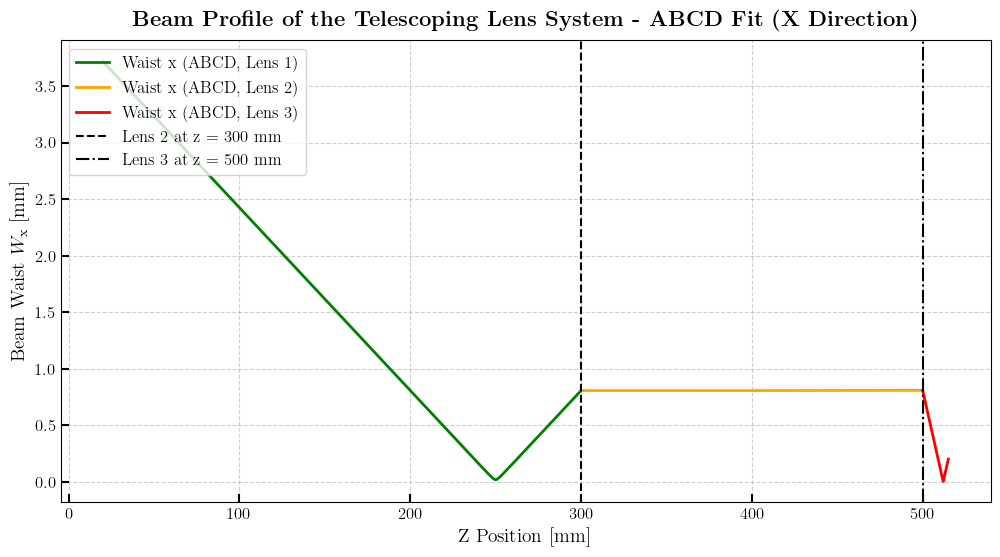

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_y_three_lenses.png


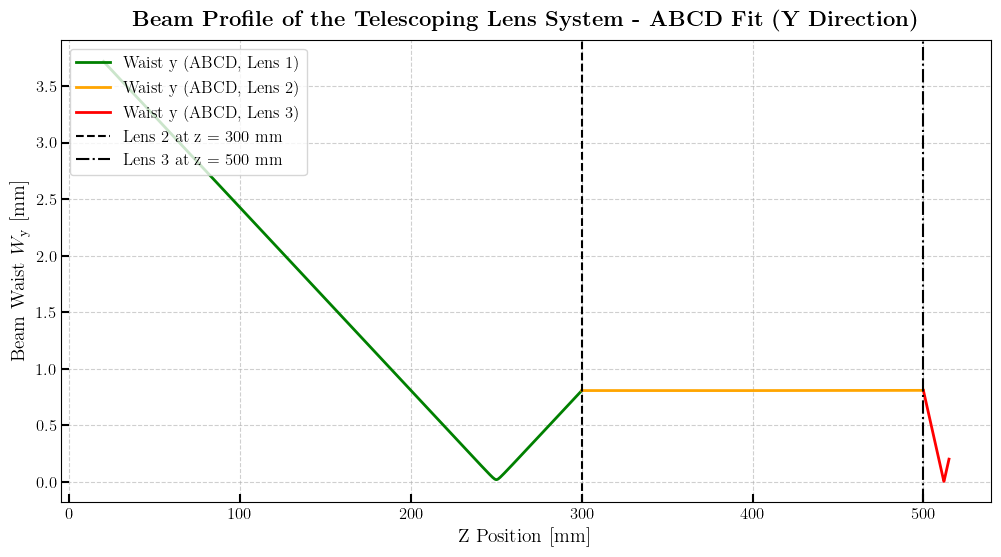

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv")) 
                     if "before lens" not in os.path.basename(f).lower()])
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values = []
width_x = []
width_y = []

# Extract first lens data:
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])  
    if z <= 149:  
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2]))  
            if "Width y" in line:
                width_y.append(float(line.split()[2]))  

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length1 = 250.0
focal_length2 = 50.0  
focal_length3 = 12.0
wavelength = 1.064e-3
z_lens2 = 300  
z_lens3 = 500

# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Waist x' or 'Waist y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0

# Beam waist after the lens (at focal length)
W0 = width_x.min()  # Minimum width from data
z_waist = z_values[np.argmin(width_x)]  # Position of the waist
z_R = np.pi * W0**2 / wavelength  # Rayleigh range at the waist in mm

# Read W0_initial from file 
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0 (before the first lens)

# Apply the first lens transformation at z = 0 
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1)  # Beam parameter just after the first lens

# Propagate to second lens position 
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)

# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
#print(f"q3 (after second lens): {q3:.2f}")

# Propagate to third lens position 
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
#print(f"q4 (before third lens at z = {z_lens3} mm): {q4:.2f}")

# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
#print(f"q5 (after third lens): {q5:.2f}")

# Theoretical z-values
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 500)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 500)
#z_theoretical3 = np.linspace(z_lens3, z_lens3 + focal_length3*1.25, 600) 
z_focal_expected = z_lens3 + focal_length3 
z_theoretical3 = np.concatenate([
    np.linspace(z_lens3, z_focal_expected - 0.5, 1000),
    np.linspace(z_focal_expected - 0.5, z_focal_expected + 0.6, 100000), 
    np.linspace(z_focal_expected + 0.5, z_lens3 + focal_length3 * 1.25, 1000)
])
#z_theoretical3 = np.linspace(z_lens3, 443.5, 600) 
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)

# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan 

# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan 

# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:  # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Waist_x = {wx:.3f} mm, Waist_y = {wy:.3f} mm")

# Conversion (mm to um) for the min waist values
min_waist_exp_x = min(width_x) * 1000
min_waist_exp_y = min(width_y) * 1000
min_waist_theo1 = min(W_theoretical1) * 1000
max_waist_theo1 = max(W_theoretical1) 
min_waist_theo2 = min(W_theoretical2)
max_waist_theo2 = max(W_theoretical2) 
min_waist_theo3 = min(W_theoretical3[~np.isnan(W_theoretical3)]) * 1000
max_waist_theo3 = max(W_theoretical3[~np.isnan(W_theoretical3)])

# Theoretical focal position after the third lens
min_waist_theo3_idx = np.argmin(W_theoretical3[~np.isnan(W_theoretical3)])
z_focal_theo3 = z_theoretical3[~np.isnan(W_theoretical3)][min_waist_theo3_idx]

print("\nBEAM WAIST SUMMARY")
print(f"Experimental (Lens 1):")
print(f"  Min Waist X: {min_waist_exp_x:.2f} μm")
print(f"  Min Waist Y: {min_waist_exp_y:.2f} μm")
print(f"Theoretical (After Lens 1):")
print(f"  Min Waist: {min_waist_theo1:.2f} μm")
print(f"  Max Waist: {max_waist_theo1:.2f} mm")
print(f"Theoretical (After Lens 2):")
print(f"  Min Waist: {min_waist_theo2:.2f} mm")
print(f"  Max Waist: {max_waist_theo2:.2f} mm")
print(f"Theoretical (After Lens 3):")
print(f"  Min Waist: {min_waist_theo3:.2f} μm at z = {z_focal_theo3:.2f} mm")
print(f"  Max Waist: {max_waist_theo3:.2f} mm")

# Plot Width x
plt.figure(figsize=(12, 6))
# Scatter plot for experimental data from lens 1
#mask1 = z_values < 300
#plt.scatter(z_values[mask1], width_x[mask1], color='blue', label='Width x (Exp., Lens 1)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Waist x (ABCD, Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the Telescoping Lens System - ABCD Fit (X Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x_three_lenses.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_x}")
plt.show()

# Plot Width y
plt.figure(figsize=(12, 6))
# Data before second lens
#plt.scatter(z_values[mask1], width_y[mask1], color='red', label='Width y (Exp., Lens 1)', marker='o', s=30)
# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='green', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 1)')
plt.plot(z_theoretical2, W_theoretical2, color='orange', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 2)')
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2, label='Waist y (ABCD, Lens 3)')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'Lens 2 at z = {z_lens2} mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'Lens 3 at z = {z_lens3} mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Waist $W_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the Telescoping Lens System - ABCD Fit (Y Direction)}', fontsize=16, fontweight='bold', pad=10)
plt.legend(loc='upper left', fontsize=12, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)
save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y_three_lenses.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_beam_ABCD_y}")
plt.show()